<h1> Feature Engineering and Modeling Process </h1>

<ul>
    <li> Reading The Data </li>
    <li> Feature Engineering  </li>
    <ol>
         <li> Creating New Features </li>
         <li> Creating Dummies </li>
         <li> Remove Unimportant Columns</li>
         <li> Scaling</li>
         <li> Removing the outliers </li>
    </ol> 
   <li> Modeling</li>
    <ol> 
       <li> Applying Random Forest </li>
       <li> Random Oversampling </li>
    </ol>
  
</ul>

<h2> Reading The Data </h2>


First of all we need to read the two datasets 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

In [2]:
client_df = pd.read_csv('client_data.csv')
price_df = pd.read_csv('price_data.csv')

In [3]:
# to display all columns in head() method
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
client_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [5]:
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


<h2> Feature Engineering </h2>

<h3> 1. Creating New Features </h3>

<p>In this task we will build out new features to uncover signals in the data that could inform the churn model.</p>

<p>This Features are : </p>
<ol> 
    <li> The difference between off-peak prices in December and January the preceding year </li>
    <li> 'Tenure' column that will represent the difference between date_end and date_activ </li>
    <li> The average of year price </li>
    <li> The average of the last six months price </li>
    <li> The average of the last three months price </li>
</ol>

In [6]:
#the difference between off-peak prices in December and January the preceding year
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [7]:
# Merging the diff dataframe with client_data
data=client_df.merge(diff,on='id')
data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,-0.006192,0.162916



<p> In the first step we created The difference between off-peak prices in December and January the preceding year </p>
<p> Now We need to create 'Tenure' column but first we should convert  the date columns to DateTime object</p>


In [8]:
# this function takes a dataframe column and converts it to DateTime object
def date_time_cvt(column):
    data[column]=pd.to_datetime(data[column])

In [9]:
# converting 'date_activ','date_end','date_modif_prod','date_renewal' to DateTime object
datetime_cols = ['date_activ','date_end','date_modif_prod','date_renewal']
for column in datetime_cols:
    date_time_cvt(column)  

In [10]:
# check our work is ok
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14606 entries, 0 to 14605
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               14606 non-null  object        
 1   channel_sales                    14606 non-null  object        
 2   cons_12m                         14606 non-null  int64         
 3   cons_gas_12m                     14606 non-null  int64         
 4   cons_last_month                  14606 non-null  int64         
 5   date_activ                       14606 non-null  datetime64[ns]
 6   date_end                         14606 non-null  datetime64[ns]
 7   date_modif_prod                  14606 non-null  datetime64[ns]
 8   date_renewal                     14606 non-null  datetime64[ns]
 9   forecast_cons_12m                14606 non-null  float64       
 10  forecast_cons_year               14606 non-null  int64    

In [11]:
# let's create Tenure column that will represent the difference between date_end and date_activ
data['tenure']=(data['date_end']-data['date_activ'])
data['tenure']=round(data['tenure']/ np.timedelta64(1,'Y'))
#data.tenure

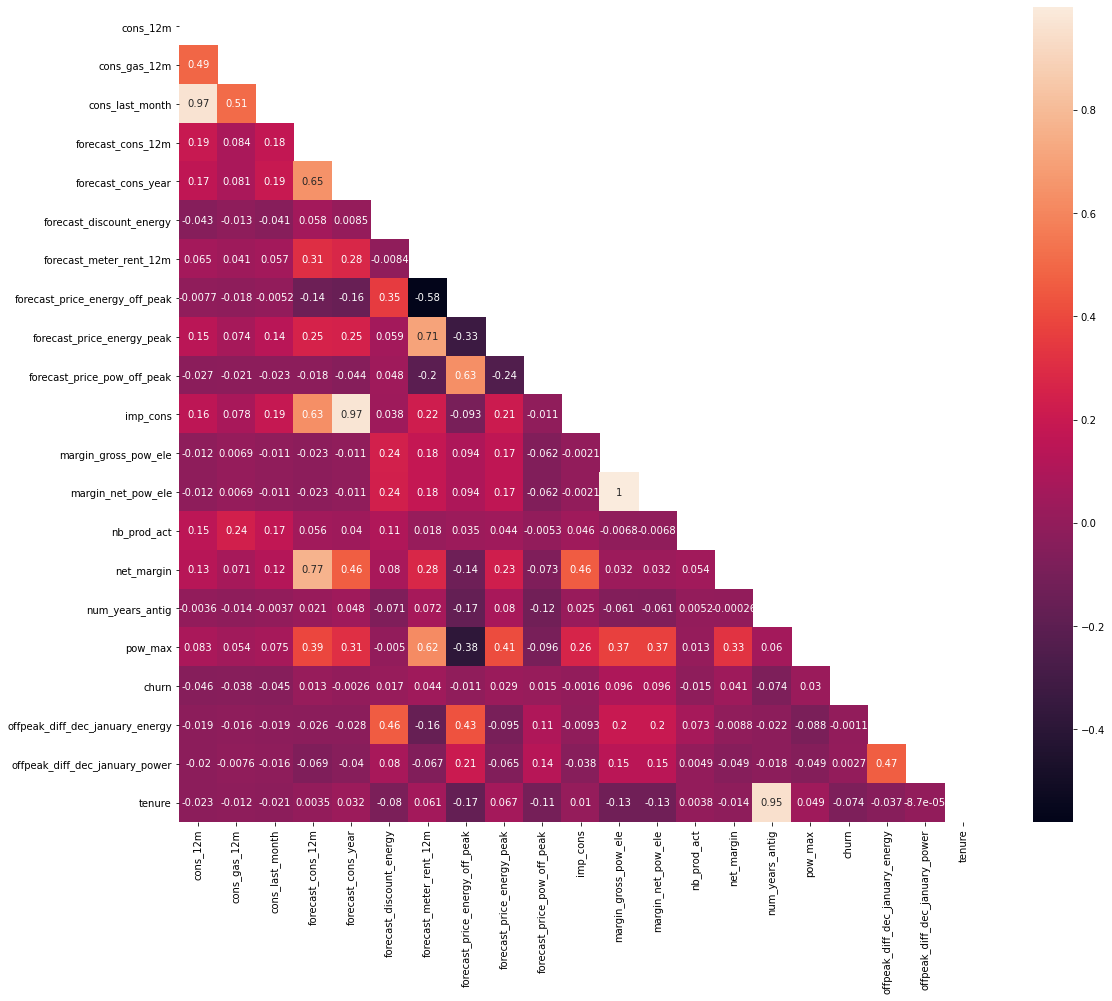

In [12]:
# visulaizing the correlation between columns in data
corr=data.corr()
plt.figure(figsize=(18,15))
mask=np.triu(np.ones_like(corr,dtype='bool'))
sns.heatmap(corr,mask=mask,annot=True);

<p> Lets create average year, last 6 months and last 3 months in the next step. </p>


In [13]:
# Creating average year price, last 6 months and last 3 months
mean_year=price_df.groupby(by=['id','price_date']).mean().groupby(by='id').mean().reset_index()
mean_6m=price_df[price_df['price_date']>'2015-06-01'].groupby(by=['id','price_date']).mean().groupby(by='id').mean().reset_index()
mean_3m =price_df[price_df["price_date"] > "2015-10-01"].groupby(["id"]).mean().reset_index()

In [14]:
mean_year.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000


In [15]:
#Adding the peak_var columns to peak_fix columns for mean_year
mean_year['mean_year_price_p1']=mean_year['price_off_peak_var']+mean_year['price_off_peak_fix']
mean_year['mean_year_price_p2']=mean_year['price_peak_var']+mean_year['price_peak_fix']
mean_year['mean_year_price_p3']=mean_year['price_mid_peak_var']+mean_year['price_mid_peak_fix']

In [16]:
mean_6m.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.121266,0.102368,0.073728,40.728885,24.43733,16.291555
1,0004351ebdd665e6ee664792efc4fd13,0.144687,0.000000,0.000000,44.444710,0.00000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.202024,0.000000,0.000000,45.944710,0.00000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.114428,0.096080,0.069418,40.728885,24.43733,16.291555
4,00114d74e963e47177db89bc70108537,0.146184,0.000000,0.000000,44.266930,0.00000,0.000000


In [17]:
#Adding the peak_var columns to peak_fix columns for mean_6m
mean_6m['mean_6m_price_p1']=mean_6m['price_off_peak_var']+mean_6m['price_off_peak_fix']
mean_6m['mean_6m_price_p2']=mean_6m['price_peak_var']+mean_6m['price_peak_fix']
mean_6m['mean_6m_price_p3']=mean_6m['price_mid_peak_var']+mean_6m['price_mid_peak_fix']

In [18]:
mean_3m.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555
1,0004351ebdd665e6ee664792efc4fd13,0.143943,0.000000,0.000000,44.444710,0.00000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.201280,0.000000,0.000000,45.944710,0.00000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.113068,0.095385,0.069409,40.728885,24.43733,16.291555
4,00114d74e963e47177db89bc70108537,0.145440,0.000000,0.000000,44.266930,0.00000,0.000000


In [19]:
mean_3m['mean_3m_price_p1']=mean_3m['price_off_peak_var']+mean_3m['price_off_peak_fix']
mean_3m['mean_3m_price_p2']=mean_3m['price_peak_var']+mean_3m['price_peak_fix']
mean_3m['mean_3m_price_p3']=mean_3m['price_mid_peak_var']+mean_3m['price_mid_peak_fix']

<p> Let's rename the columns in the three data frame and merging them with our data </p>

In [20]:
# Rename columns in mean_year
mean_year = mean_year.rename(
    index=str, 
    columns={
        "price_p1_var": "mean_year_price_p1_var",
        "price_p2_var": "mean_year_price_p2_var",
        "price_p3_var": "mean_year_price_p3_var",
        "price_p1_fix": "mean_year_price_p1_fix",
        "price_p2_fix": "mean_year_price_p2_fix",
        "price_p3_fix": "mean_year_price_p3_fix"
    }
)

In [21]:
# check our work is ok
mean_year.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,44.531877,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,45.501268,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,40.766185,24.486748,16.328003
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,44.414856,0.000000,0.000000


In [22]:
# Rename columns in mean_6m
mean_6m = mean_6m.rename(
    index=str, 
    columns={
        "price_p1_var": "mean_6m_p1_var",
        "price_p2_var": "mean_6m_p2_var",
        "price_p3_var": "mean_6m_p3_var",
        "price_p1_fix": "mean_6m_p1_fix",
        "price_p2_fix": "mean_6m_p2_fix",
        "price_p3_fix": "mean_6m_p3_fix"
    }
)

In [23]:
# check our work is ok
mean_6m.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3
0,0002203ffbb812588b632b9e628cc38d,0.121266,0.102368,0.073728,40.728885,24.43733,16.291555,40.850151,24.539698,16.365283
1,0004351ebdd665e6ee664792efc4fd13,0.144687,0.000000,0.000000,44.444710,0.00000,0.000000,44.589397,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.202024,0.000000,0.000000,45.944710,0.00000,0.000000,46.146734,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.114428,0.096080,0.069418,40.728885,24.43733,16.291555,40.843313,24.533410,16.360973
4,00114d74e963e47177db89bc70108537,0.146184,0.000000,0.000000,44.266930,0.00000,0.000000,44.413114,0.000000,0.000000


In [24]:
# Rename columns in mean_6m
mean_3m = mean_3m.rename(
    index=str, 
    columns={
        "price_p1_var": "mean_3m_p1_var",
        "price_p2_var": "mean_3m_p2_var",
        "price_p3_var": "mean_3m_p3_var",
        "price_p1_fix": "mean_3m_p1_fix",
        "price_p2_fix": "mean_3m_p2_fix",
        "price_p3_fix": "mean_3m_p3_fix"
    }
)

In [25]:
# check our work is ok
mean_3m.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3
0,0002203ffbb812588b632b9e628cc38d,0.119906,0.101673,0.073719,40.728885,24.43733,16.291555,40.848791,24.539003,16.365274
1,0004351ebdd665e6ee664792efc4fd13,0.143943,0.000000,0.000000,44.444710,0.00000,0.000000,44.588653,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.201280,0.000000,0.000000,45.944710,0.00000,0.000000,46.145990,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.113068,0.095385,0.069409,40.728885,24.43733,16.291555,40.841953,24.532715,16.360964
4,00114d74e963e47177db89bc70108537,0.145440,0.000000,0.000000,44.266930,0.00000,0.000000,44.412370,0.000000,0.000000


In [26]:
#merging to the main data
data=data.merge(mean_year,on='id')
data=data.merge(mean_6m,on='id')
data=data.merge(mean_3m,on='id')

In [27]:
data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,tenure,price_off_peak_var_x,price_peak_var_x,price_mid_peak_var_x,price_off_peak_fix_x,price_peak_fix_x,price_mid_peak_fix_x,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,price_off_peak_var_y,price_peak_var_y,price_mid_peak_var_y,price_off_peak_fix_y,price_peak_fix_y,price_mid_peak_fix_y,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961,3.0,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779,7.0,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779,6.0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779,6.0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,-0.006192,0.162916,6.0,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,40.850151,24.539698,16.365283,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274


<h3> 2. Creating Dummies </h3>

<p>In this task we will create dummies for important categorical features that will help us in modeling stage </p>

<p>This Features are : </p>
<ol> 
    <li> 'channel_sales' column </li>
    <li> 'origin_up' column </li>
    <li> 'has_gas' column </li>
</ol>

<p> 
    Let's begin with 'channel_sales' column, first of all we need to understand it and then create dummies for it based on our understanding
</p>

In [28]:
# display the counts of unique values in that column
counts=data['channel_sales'].value_counts()
print(counts)

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64


In [29]:
# set the channel_sales that are less 100 to 'other'
other = data['channel_sales'].isin(counts[counts<100].index)
data['channel_sales'][other]='other'
print(data['channel_sales'].value_counts())

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
other                                 16
Name: channel_sales, dtype: int64


<ipython-input-29-6625380115d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['channel_sales'][other]='other'


In [30]:
#create dummies for channel_sales column
channel_sales=pd.get_dummies(data['channel_sales'],prefix='channel',drop_first=True)
#Renaming the column
channel_sales.columns=[col_name[:10] for col_name in channel_sales.columns ]
channel_sales.head()

,channel_ew,channel_fo,channel_lm,channel_ot,channel_us
0,0,1,0,0,0
1,0,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0



<p> 
    And we will do the same thing for 'origin_up' column, first understand it and then create dummies for it.  
</p>

In [31]:
# display the counts of unique values in that column
counts=data['origin_up'].value_counts()
print(counts)

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64


In [32]:
# set the channel_sales that are less 100 to 'other'
#set all the origin_up that are less than 100 to 'other'
other=data['origin_up'].isin(counts[counts<100].index)
data['origin_up'][other]='other'
print(data['origin_up'].value_counts())

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
other                                 67
Name: origin_up, dtype: int64


<ipython-input-32-12a4dcd66e28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['origin_up'][other]='other'


In [33]:
#create dummies for origin_up  column
origin_up=pd.get_dummies(data['origin_up'],prefix='origin',drop_first=True)
#Renaming the column
origin_up.columns=[col_name[:10] for col_name in origin_up.columns ]
origin_up.head()

,origin_ldk,origin_lxi,origin_oth
0,0,1,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


 <p> Let's merge our dummies with our dataframe </p>

In [34]:
data=data.merge(channel_sales,left_index=True,right_index=True)
data=data.merge(origin_up,left_index=True,right_index=True)
data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,tenure,price_off_peak_var_x,price_peak_var_x,price_mid_peak_var_x,price_off_peak_fix_x,price_peak_fix_x,price_mid_peak_fix_x,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,price_off_peak_var_y,price_peak_var_y,price_mid_peak_var_y,price_off_peak_fix_y,price_peak_fix_y,price_mid_peak_fix_y,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,channel_ew,channel_fo,channel_lm,channel_ot,channel_us,origin_ldk,origin_lxi,origin_oth
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961,3.0,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,0,1,0,0,0,0,1,0
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779,7.0,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,0,0,0,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779,6.0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,1,0,0,0,0,0,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779,6.0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.149330,0.000000,0.000000,44.444710,0.000000,0.000000,44.594040,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,0,1,0,0,0,0,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,-0.006192,0.162916,6.0,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,40.812330,24.516531,16.348129,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,40.850151,24.539698,16.365283,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,0,0,0,0,0,0,0


<p> For 'has_gas' column it contains only two values 't' and 'f' , we need to replace them with 1 , 0 respectively

In [35]:
data['has_gas'].value_counts()

f    11955
t     2650
Name: has_gas, dtype: int64

In [36]:
# replace 't' with 1 and 'f' with 0 
data['has_gas']=data['has_gas'].replace({'t':1,'f':0})

<h3> 3. Remove Unimportant Columns </h3>

<p>In this task we will remove unimportant features which don't have an influential role in the modeling stage </p>

<p>This Features are : </p>
<ol> 
    <li> 'channel_sales' column </li>
    <li> 'origin_up' column </li>
    <li> 'date_activ' column </li>
    <li> 'id' column </li>
    <li> 'date_end' column </li>
    <li> 'date_modif_prod' column </li>
    <li> 'date_renewal' column </li>
</ol>

In [37]:
# drop unimportant columns
data=data.drop(['channel_sales','origin_up','id','date_activ','date_end','date_modif_prod','date_renewal'],axis=1)

In [38]:
# display the shape of our data after droping these columns
data.shape

(14605, 57)

In [39]:
# check our work
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14604
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cons_12m                         14605 non-null  int64  
 1   cons_gas_12m                     14605 non-null  int64  
 2   cons_last_month                  14605 non-null  int64  
 3   forecast_cons_12m                14605 non-null  float64
 4   forecast_cons_year               14605 non-null  int64  
 5   forecast_discount_energy         14605 non-null  float64
 6   forecast_meter_rent_12m          14605 non-null  float64
 7   forecast_price_energy_off_peak   14605 non-null  float64
 8   forecast_price_energy_peak       14605 non-null  float64
 9   forecast_price_pow_off_peak      14605 non-null  float64
 10  has_gas                          14605 non-null  int64  
 11  imp_cons                         14605 non-null  float64
 12  margin_gross_pow_e

<h3> 4. Scaling </h3>

<p>In this task we will normalize our feature using PowerTransformer </p>

<p><b>Power transforms</b> are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.</p>

<h5> Steps for this task </h5>
<ol> 
    <li> Scaling some columns in our dataset </li>
    <li> Visualize the distrbution for some columns after scalling </li>
</ol>

In [40]:
# scaling 
from sklearn.preprocessing import PowerTransformer
pow_trans = PowerTransformer()
scale=data.drop(['channel_ew','channel_fo','channel_lm','channel_ot','channel_us','origin_ldk','origin_lxi','origin_oth','tenure',
          'num_years_antig','has_gas','churn'],axis=1).columns
data[scale]=pow_trans.fit_transform(data[scale])

In [41]:
data.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,tenure,price_off_peak_var_x,price_peak_var_x,price_mid_peak_var_x,price_off_peak_fix_x,price_peak_fix_x,price_mid_peak_fix_x,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,price_off_peak_var_y,price_peak_var_y,price_mid_peak_var_y,price_off_peak_fix_y,price_peak_fix_y,price_mid_peak_fix_y,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,channel_ew,channel_fo,channel_lm,channel_ot,channel_us,origin_ldk,origin_lxi,origin_oth
0,-4.280763,2.160741,-1.251591,-2.612675,-1.116664,-0.190412,-1.695050,-0.927744,0.972190,-0.755325,1,-1.091254,0.283211,0.283382,1.880537,1.791599,3,1.909634,1,2.055561,2.745210,3.0,-0.802726,0.976276,1.176151,-0.631555,1.237607,1.246851,-0.635495,1.236827,1.246786,-0.710952,0.942249,1.097927,-0.535094,1.214427,1.220303,-0.538787,1.213475,1.220288,-0.324481,0.836802,0.609541,-0.235197,1.053055,1.039091,-0.237243,1.051620,1.039300,0,1,0,0,0,0,1,0
1,-0.646606,-0.466448,-1.251591,-1.191149,-1.116664,-0.190412,-0.591146,0.336408,-1.030050,0.265452,0,-1.091254,-0.309881,-0.309729,-0.526885,-1.292515,6,-0.187735,0,0.099349,-0.088437,7.0,0.301519,-0.899822,-0.792848,0.325867,-0.793309,-0.792985,0.326806,-0.806737,-0.793125,0.307247,-0.747443,-0.790065,0.315476,-0.789538,-0.789289,0.316402,-0.794607,-0.789437,0.329376,-1.036944,-0.788376,0.314116,-0.787674,-0.787448,0.315185,-0.810022,-0.787592,0,0,0,0,0,0,0,0
2,-1.644563,-0.466448,-1.251591,-1.766114,-1.116664,-0.190412,0.038161,1.161285,0.766808,0.265452,0,-1.091254,0.456646,0.456820,-0.526885,-1.820611,6,-0.174261,0,0.020506,-0.088437,6.0,1.289494,0.731324,-0.792848,0.347939,-0.793309,-0.792985,0.355062,-0.715434,-0.793125,1.204887,0.751868,-0.790065,0.341447,-0.789538,-0.789289,0.348366,-0.710919,-0.789437,1.180398,0.752266,-0.788376,0.314116,-0.787674,-0.787448,0.321028,-0.708971,-0.787592,0,1,0,0,0,0,0,0
3,-1.154915,-0.466448,-1.251591,-1.069990,-1.116664,-0.190412,-0.457214,0.376567,-1.030050,0.265452,0,-1.091254,0.540670,0.540846,-0.526885,-1.115469,6,-0.339798,0,0.031267,-0.088437,6.0,0.375291,-1.044108,-0.792848,0.352358,-0.793309,-0.792985,0.353726,-0.815242,-0.793125,0.370465,-1.039498,-0.790065,0.341447,-0.789538,-0.789289,0.342749,-0.811674,-0.789437,0.370465,-1.036944,-0.788376,0.314116,-0.787674,-0.787448,0.315470,-0.810022,-0.787592,0,0,1,0,0,0,0,0
4,-0.671302,-0.466448,0.198967,-0.710055,0.552152,-0.190412,1.123625,-0.830638,1.009659,-0.755325,0,0.431746,1.192675,1.192854,-0.526885,-0.697606,6,0.796037,0,-0.113193,-0.099705,6.0,-0.829064,1.033588,1.259066,-0.700105,1.262430,1.274297,-0.704022,1.261787,1.274206,-0.807021,1.026891,1.263801,-0.691986,1.265938,1.277376,-0.695823,1.265255,1.277295,-0.805668,1.017064,1.261317,-0.708714,1.267465,1.278505,-0.712532,1.266749,1.278426,0,0,0,0,0,0,0,0


C:\Users\Blu-Ray\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


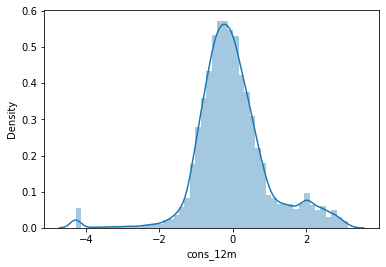

In [42]:
sns.distplot(data['cons_12m']);

C:\Users\Blu-Ray\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


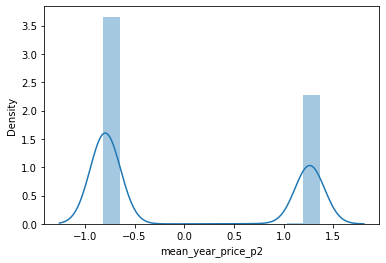

In [43]:
sns.distplot(data['mean_year_price_p2']);

<h3> 4. Removing the outliers </h3>

<p>In this task we will remove outliers from our dataset </p>

<p><b> Outliers </b>are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.</p>


In [44]:
#Removing outliers
for i in scale:
    std=data[i].std()
    mean=data[i].mean()
    cut_off=3*std
    lower,upper=mean-cut_off,mean+cut_off
    data=data[(data[i]<upper) & (data[i]> lower)]


In [45]:
# check the shape of our dataframe
data.shape

(12743, 57)

<h2> Modeling </h2>

<h3> 1. Applying Random Forest </h3>

<p>It is time to build a predictive model to see how well these features are able to predict a customer churning. We will apply a Random Forest classifier and to evaluate the results in an appropriate manner.</p>

<p>So we need to split our data to trainging and testing sets. After that we run a RandomForestClassifier on the sets, then we calculate accuracy, recall and precision  </p>


In [46]:
#spliting the data to X and y
X=data.drop('churn',axis=1)
y=data['churn']

In [47]:
#spliting the data to training and testing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1111)

In [48]:
# check the shape for our training and testing sets
print(f"The shape of our training set is: {X_train.shape}")
print(f"The shape of our testing set is: {X_test.shape}")

The shape of our training set is: (10194, 56)
The shape of our testing set is: (2549, 56)


In [49]:
# apply RandomForestClassifier
rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [50]:
# calculate score of our model
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

1.0
0.9176147508826991


In [51]:
# creating a function to evaluate the model
def evaluation(model,y_pred):
    train_score=model.score(X_train,y_train)
    test_score=model.score(X_test,y_test)
    print('the training score is {}'.format(round(train_score,2)))
    print('the test score is {}'.format(round(test_score,2)))
    print('_________________________________')
    from sklearn.metrics import confusion_matrix,recall_score,precision_score,accuracy_score
    print('The confusion matrix is')
    print(confusion_matrix(y_test,y_pred))
    print('_________________________________')
    recall=recall_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    accuracy=accuracy_score(y_test,y_pred)
    print('recall score is {}'.format(round(recall,2)))
    print('precision score is {}'.format(round(precision,2)))
    print('Accuracy score is {}'.format(round(accuracy,2)))

In [52]:
evaluation(rf,y_pred)

the training score is 1.0
the test score is 0.92
_________________________________
The confusion matrix is
[[2328    3]
 [ 207   11]]
_________________________________
recall score is 0.05
precision score is 0.79
Accuracy score is 0.92


In [53]:
y_test.value_counts()

0    2331
1     218
Name: churn, dtype: int64

<p> <b>performance of your model</b> </p>

<ul>
    <li> Out of 2331 of the negative values, the model predected 2327 right which is very great </li>
    <li> Out of 218 of the posivtive values the model predected 11 right which is very poor performance </li>
</ul>

<h3> 2. Random Oversampling </h3>

<p> This tecnique will help us to improve the performance of our data</p>

<p>Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset and that is really helpful  </p>

In [54]:
from imblearn.over_sampling import SMOTE

In [55]:
# SMOTE is used to balance the dataset for each class label
oversampling=SMOTE()
X,y=oversampling.fit_resample(X,y)
y.value_counts()

0    11549
1    11549
Name: churn, dtype: int64

<p> So now our class labels are balanced. </p>
<p> Let's run RandomForestClassifier on our balanced sets and see the results. </p>

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

1.0
0.9558441558441558


In [57]:
evaluation(rf,y_pred)

the training score is 1.0
the test score is 0.96
_________________________________
The confusion matrix is
[[2267   50]
 [ 154 2149]]
_________________________________
recall score is 0.93
precision score is 0.98
Accuracy score is 0.96


In [58]:
y_test.value_counts()

0    2317
1    2303
Name: churn, dtype: int64

<p> <b>Performance is getting better </b> </p>
<ul>
    <li> so out of 2317 of the negative values, the model predected 2267 right which is great so far</li>
    <li>but out of 2303 of the posivtive values the model predected 2149 right which is awesome</li>
</ul>